# Modelo de deteccion de phishing en URLs
### Modelos a utilizar: SVM, Random Forest y Naive Bayes

Referencias:  
Tiwari, T. (2020). Phishing Site URLs https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls?resource=download


#### Analisis Exploratorio

In [3]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# Get sklearn version
import sklearn
print(sklearn.__version__)

1.5.2


In [5]:
df = pd.read_csv("datasets/URLs/phishing_site_urls.csv")
df.head(10)

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
5,smilesvoegol.servebbs.org/voegol.php,bad
6,premierpaymentprocessing.com/includes/boleto-2...,bad
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,bad
8,super1000.info/docs,bad
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,bad


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [7]:
df.shape

(549346, 2)

La data consiste de 549346 filas que contienen su respectivo URL y etiqueta que denota si el URL es seguro (good) o es malicioso/phishing (bad).

In [8]:
df[df.Label == 'good'].sample(5)

,URL,Label
403636,newegg.com/Product/Product.aspx?Item=N82E16834...,good
445223,theglobeandmail.com/news/technology/tech-news/...,good
410027,onwardoverland.com/formula/formula2001/formula...,good
300046,cato.org/pub_display.php?pub_id=5880,good
475594,youtube.com/watch?v=ak75wt79d58,good


In [9]:
df[df.Label == 'bad'].sample(5)

,URL,Label
14852,skylinerxx.comxa.com/INDEX.PHP,bad
28040,villakidsbuffetinfantil.com/Limit-id=65722/173...,bad
37196,www.comboind.com.au/images/remax/,bad
505980,dedivan.ru/index.php?categoryID=65,bad
116563,bastionps.co.za/file-secured/secured-file/,bad


In [10]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

<Axes: xlabel='Label', ylabel='count'>

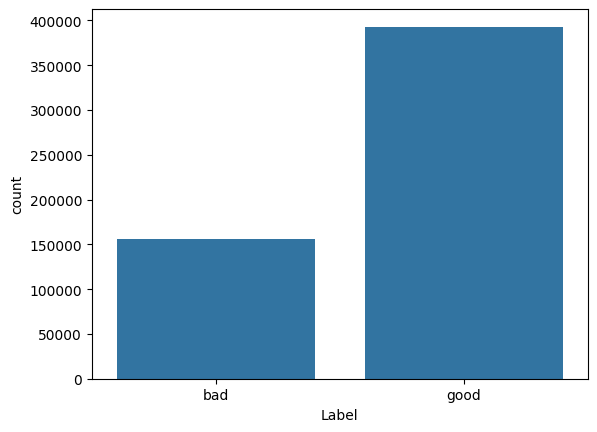

In [11]:
sns.countplot(x='Label', data=df)

#### Ingenieria de Caracteristicas

In [12]:
from six.moves import cPickle as pickle
with open('datasets/URLs/d_common_en_words' + '.pickle', 'rb') as f:
    d = pickle.load(f)

In [13]:
def entropyShanon (x):
    # Calculate Shannon Entropy
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ]
    H = - sum([ p * np.log2(p) for p in prob ])
    return H

def firstDigitIndex(s):
    for i, c in enumerate(s):
        if c.isdigit():
            return i + 1
    return 0

def vowel_consonant_ratio (x):
    # Calculate vowel to consonant ratio
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception
        ratio = 0
    return ratio

# ngrams: Implementation according to Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence"
# http://s2lab.isg.rhul.ac.uk/papers/files/dimva2014.pdf

def ngrams(word, n):
    # Extract all ngrams and return a regular Python list
    # Input word: can be a simple string or a list of strings
    # Input n: Can be one integer or a list of integers
    # if you want to extract multipe ngrams and have them all in one list

    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams

def ngram_feature(domain, d, n):
    # Input is your domain string or list of domain strings
    # a dictionary object d that contains the count for most common english words
    # finally you n either as int list or simple int defining the ngram length

    # Core magic: Looks up domain ngrams in english dictionary ngrams and sums up the
    # respective english dictionary counts for the respective domain ngram
    # sum is normalized

    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if d[ngram]:
            count_sum+=d[ngram]
    try:
        feature = count_sum/(len(domain)-n+1)
    except:
        feature = 0
    return feature

def average_ngram_feature(l_ngram_feature):
    # input is a list of calls to ngram_feature(domain, d, n)
    # usually you would use various n values, like 1,2,3...
    return sum(l_ngram_feature)/len(l_ngram_feature)


#Extraido de https://redcanary.com/blog/threat-hunting-entropy/
def relative_entropy(data):
    # Remove TLDs and instances of 'www' so 'www.google.com' would be treated as 'google' and 'images.google.com' would be 'images.google'.
    
    # print(data)
    data = data.replace('www.', '')
    # Remove http:// and https://.
    data = data.split('://')[-1]
    # Remove subdomains.
    data = data.split('.')[0]

    if "/" in data:
        data = data.split('/')[0]

    data = data.lower()

    #Calculate the relative entropy (Kullback-Leibler divergence) between data and expected values.
    entropy = 0.0
    length = len(data) * 1.0

    try:

        if length > 0:
            cnt = Counter(data)

            # These probability numbers were calculated from the Alexa Top
            # 1 million domains as of September 15th, 2017. TLDs and instances
            # of 'www' were removed so 'www.google.com' would be treated as
            # 'google' and 'images.google.com' would be 'images.google'.
            probabilities = {
                '-': 0.013342298553905901,
                '_': 9.04562613824129e-06,
                '0': 0.0024875471880163543,
                '1': 0.004884638114650296,
                '2': 0.004373560237839663,
                '3': 0.0021136613076357144,
                '4': 0.001625197496170685,
                '5': 0.0013070929769758662,
                '6': 0.0014880054997406921,
                '7': 0.001471421851820583,
                '8': 0.0012663876593537805,
                '9': 0.0010327089841158806,
                'a': 0.07333590631143488,
                'b': 0.04293204925644953,
                'c': 0.027385633133525503,
                'd': 0.02769469202658208,
                'e': 0.07086192756262588,
                'f': 0.01249653250998034,
                'g': 0.038516276096631406,
                'h': 0.024017645001386995,
                'i': 0.060447396668797414,
                'j': 0.007082725266242929,
                'k': 0.01659570875496002,
                'l': 0.05815885325582237,
                'm': 0.033884915513851865,
                'n': 0.04753175014774523,
                'o': 0.09413783122067709,
                'p': 0.042555148167356144,
                'q': 0.0017231917793349655,
                'r': 0.06460084667060655,
                's': 0.07214640647425614,
                't': 0.06447722311338391,
                'u': 0.034792493336388744,
                'v': 0.011637198026847418,
                'w': 0.013318176884203925,
                'x': 0.003170491961453572,
                'y': 0.016381628936354975,
                'z': 0.004715786426736459,
            }

            for char, count in cnt.items():
                observed = count / length
                expected = probabilities[char]
                entropy += observed * np.log2(observed / expected)

            return entropy
        
    except Exception as e:
        return
    

# Presencia de direccion IP en la URL
def ip_address_presence (x):
    # Check for IP address in URL
    ip_pattern = re.compile('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)')
    if re.search(ip_pattern, x):
        return 1
    else:
        return 0


# Caracteres especiales en la URL
def special_chars_presence (x):
    # Check for special characters in URL
    special_chars_pattern = re.compile('([%$&+,:;=?@#|])')
    if re.search(special_chars_pattern, x):
        return 1
    else:
        return 0

# Presencia de puertos en la URL
def port_presence (x):
    # Check for port in URL
    port_pattern = re.compile('(:[0-9]+)')
    if re.search(port_pattern, x):
        return 1
    else:
        return 0

# Cantidad de subdominios en la URL
def subdomain_count (x):
    # Count subdomains
    subdomains = x.split('.')
    return len(subdomains)

# Cantidad de terminos comunes en la URL (www, com, net, org, etc)

def common_terms_count (x):
    # Count common terms
    common_terms = ['www', 'com', 'net', 'org', 'info', 'biz', 'us', 'uk', 'ca', 'de', 'jp', 'fr', 'au', 'in', 'it', 'cn', 'gov', 'https', 'http', '//']
    count = 0
    for term in common_terms:
        if term in x:
            count += 1
    return count

# Presencia de guiones en la URL
def hyphen_presence (x):
    # Check for hyphens in URL
    hyphen_pattern = re.compile('(-)')
    if re.search(hyphen_pattern, x):
        return 1
    else:
        return 0

# Presencia de doble guion bajo en la URL
def double_hyphen_presence (x):
    # Check for double hyphens in URL
    double_hyphen_pattern = re.compile('(__)')
    if re.search(double_hyphen_pattern, x):
        return 1
    else:
        return 0

# URL Acortada
def shortening_service_presence (x):
    # Check for shortening service in URL
    shortening_services = ['bit.ly', 'goo.gl', 'tinyurl.com', 'ow.ly', 't.co', 'tiny.cc', 'bit.do', 'mcaf.ee', 'cli.gs', 'yfrog.com', 'twit.ac', 'su.pr', 'lnkd.in', 'db.tt', 'qr.ae', 'adf.ly', 'goo.gl', 'bitly.com', 'cur.lv', 'tiny.cl', 'po.st', 'bc.vc', 'twitthis.com', 'u.to', 'j.mp', 'buzurl.com', 'cutt.us', 'u.bb', 'yourls.org', 'x.co', 'prettylinkpro.com', 'scrnch.me', 'filoops.info', 'vzturl.com', 'qr.net', '1url.com', 'tweez.me', 'v.gd', 'tr.im', 'link.zip.net']
    for service in shortening_services:
        if service in x:
            return 1
    return 0

# Subdominios abnormales
def abnormal_subdomain_presence (x):
    # Check for abnormal subdomains
    abnormal_subdomains = ['sc', 'dc', 'oc', 'ac', 'info', 'mail', 'home', 'corp', 'download', 'product', 'support', 'payment', 'login', 'secure', 'account', 'admin', 'administrator', 'root', 'blog', 'blogspot', 'wordpress', 'web', 'webs', 'website', 'net', 'org', 'in', 'co', 'cc', 'biz', 'info', 'name', 'pro', 'tel', 'mobi', 'aero', 'asia', 'cat', 'coop', 'jobs', 'museum', 'travel', 'arpa', 'root', 'local', 'onion', 'example', 'invalid', 'test', 'localhost', 'localdomain', 'local']
    for subdomain in x.split('.'):
        if subdomain in abnormal_subdomains:
            return 1
    return 0

#### Preprocesamiento

In [14]:
df['URL'] = df['URL'].str.strip("'")

In [15]:
df['ngrams'] = df['URL'].apply(lambda x: average_ngram_feature([ngram_feature(x, d, 1),
                                                                ngram_feature(x, d, 2),
                                                                ngram_feature(x, d, 3)]))

df['entropy'] = df['URL'].apply(entropyShanon)
df['entropyRelative'] = df['URL'].apply(relative_entropy)
df['vowel-cons'] = df['URL'].apply(vowel_consonant_ratio)
df['firstDigitIndex'] = df['URL'].apply(firstDigitIndex)
df['length'] = df['URL'].str.len()
df['digits'] = df['URL'].str.count('[0-9]')

#Ip address presence
df['ip'] = df['URL'].apply(ip_address_presence)
#Special characters presence
df['special'] = df['URL'].apply(special_chars_presence)
#Port presence
df['port'] = df['URL'].apply(port_presence)
#Subdomain count
df['subdomain'] = df['URL'].apply(subdomain_count)
#Common terms count
df['common'] = df['URL'].apply(common_terms_count)
#Hyphen presence
df['hyphen'] = df['URL'].apply(hyphen_presence)
#Double hyphen presence
df['doubleHyphen'] = df['URL'].apply(double_hyphen_presence)
#Shortening service presence
df['shortening'] = df['URL'].apply(shortening_service_presence)
#Abnormal subdomain presence
df['abnormal'] = df['URL'].apply(abnormal_subdomain_presence)

df['Label'] = df['Label'].map({'good': 0, 'bad': 1})
print(df["Label"].value_counts())
df.sample(n=10).head()


Label
0    392924
1    156422
Name: count, dtype: int64


,URL,Label,ngrams,entropy,entropyRelative,vowel-cons,firstDigitIndex,length,digits,ip,special,port,subdomain,common,hyphen,doubleHyphen,shortening,abnormal
20910,www.aquafiltersrbija.rs/account_update.htm,1,1126.853426,4.282099,1.235371,0.541667,0,42,0,0,0,0,4,1,0,0,0,0
242660,springvalley.govoffice.com/,0,1136.375119,3.986188,1.047877,0.500000,0,27,0,0,0,0,3,3,0,0,0,0
46341,www.fenetlaw.com/components/www.bradesco.com.br/,1,1060.118865,3.852974,1.801713,0.379310,0,48,0,0,0,0,6,4,0,0,0,0
378006,linuxjournal.com/article/4832,0,1061.380238,4.142295,1.690809,0.692308,26,29,4,0,0,0,2,2,0,0,0,0
181268,en.wikipedia.org/wiki/The_High_Dials,0,1048.389356,4.047526,3.106905,0.764706,0,36,0,0,0,0,3,1,0,0,0,0


<Axes: xlabel='Label', ylabel='count'>

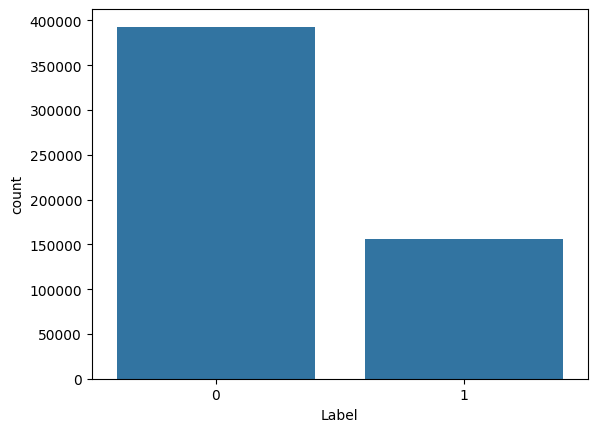

In [16]:
sns.countplot(x='Label', data=df)

#### Balanceo de data

In [17]:
# Balanceo de data
# Under-sampling
safe_urls = df[df['Label'] == 0]
phishing_urls = df[df['Label'] == 1]
safe_urls = safe_urls.sample(phishing_urls.shape[0])

data = pd.concat([safe_urls, phishing_urls], axis=0, ignore_index=True)


In [18]:
# Remove URL column
data = data.drop(['URL'], axis=1)
data.head()

,Label,ngrams,entropy,entropyRelative,vowel-cons,firstDigitIndex,length,digits,ip,special,port,subdomain,common,hyphen,doubleHyphen,shortening,abnormal
0,0,733.971544,4.179776,4.638259,0.352941,23,39,10,0,0,0,4,1,0,0,0,0
1,0,900.355032,4.775687,0.935447,0.684211,0,76,0,0,1,0,3,4,0,0,0,0
2,0,1343.118718,4.008985,1.478395,0.428571,0,45,0,0,0,0,3,3,0,0,0,0
3,0,783.148162,4.810081,2.407407,0.565217,45,54,10,0,0,0,2,1,1,0,0,0
4,0,1281.437378,4.161730,1.218295,0.689655,0,56,0,0,0,0,4,3,1,0,0,0


In [19]:
# Randomize positions of rows
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Label,ngrams,entropy,entropyRelative,vowel-cons,firstDigitIndex,length,digits,ip,special,port,subdomain,common,hyphen,doubleHyphen,shortening,abnormal
0,1,754.336797,4.659387,1.481458,0.428571,14,38,6,0,0,0,2,1,0,0,0,0
1,1,1291.813636,4.134990,1.177833,0.640000,0,46,0,0,0,0,3,2,0,0,0,0
2,1,811.504710,5.468535,0.881039,0.373832,44,172,8,0,1,0,6,3,1,1,0,0
3,1,1118.769756,3.822182,1.703366,0.625000,0,34,0,0,0,0,2,0,0,1,0,0
4,0,827.444614,4.467189,2.220092,0.435897,18,82,14,0,0,0,4,2,1,0,1,1


In [20]:
# Clean NaN values
data = data.dropna()
data.isnull().sum()

Label              0
ngrams             0
entropy            0
entropyRelative    0
vowel-cons         0
firstDigitIndex    0
length             0
digits             0
ip                 0
special            0
port               0
subdomain          0
common             0
hyphen             0
doubleHyphen       0
shortening         0
abnormal           0
dtype: int64

(312692, 17)


<Axes: xlabel='Label', ylabel='count'>

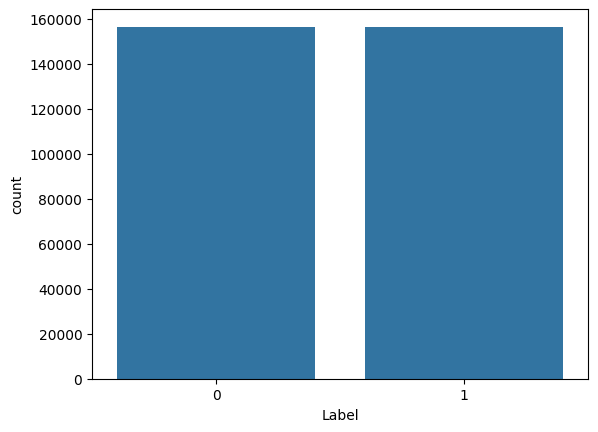

In [21]:
print(data.shape)
sns.countplot(x='Label', data=data)

In [22]:
# Guardar el dataset limpio
data.to_csv('datasets/URLs/phishing_site_urls_clean.csv', index=False)

In [23]:
data = pd.read_csv('datasets/URLs/phishing_site_urls_clean.csv')

# Entrenamiento de modelos

### Modelos a utilizar: SVM, Random Forest y Naive Bayes

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

X = data.drop('Label', axis=1)
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(234519, 16)
(78173, 16)
(234519,)
(78173,)


### LazyPredict

In [24]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [3:22:52<00:00, 419.72s/it]   

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.88               0.88     0.88      0.88   
RandomForestClassifier             0.88               0.88     0.88      0.88   
BaggingClassifier                  0.87               0.87     0.87      0.87   
DecisionTreeClassifier             0.83               0.83     0.83      0.83   
XGBClassifier                      0.82               0.82     0.82      0.82   
ExtraTreeClassifier                0.82               0.82     0.82      0.82   
KNeighborsClassifier               0.81               0.81     0.81      0.81   
LGBMClassifier                     0.80               0.80     0.80      0.80   
NuSVC                              0.79               0.79     0.79      0.79   
SVC                                0.78               0.78     0.78      0.78   
AdaBoostClassifier          

In [25]:
# Show the top 5 models
models.head(5)


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.88,0.88,0.88,0.88,47.09
RandomForestClassifier,0.88,0.88,0.88,0.88,72.42
BaggingClassifier,0.87,0.87,0.87,0.87,35.52
DecisionTreeClassifier,0.83,0.83,0.83,0.83,4.45
XGBClassifier,0.82,0.82,0.82,0.82,12.96


#### Random Forest

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     39093
           1       0.89      0.87      0.88     39080

    accuracy                           0.88     78173
   macro avg       0.88      0.88      0.88     78173
weighted avg       0.88      0.88      0.88     78173



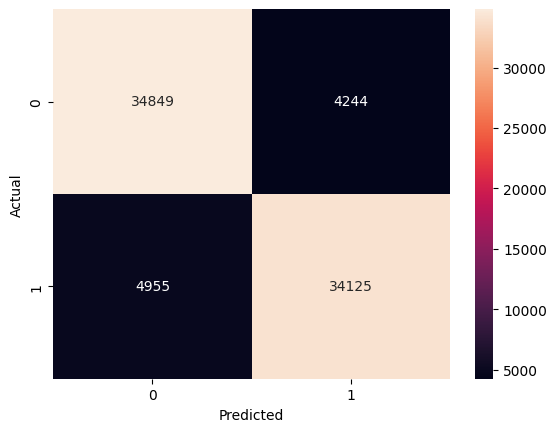

In [26]:
model_Random_Forest = RandomForestClassifier(n_estimators=100)
model_Random_Forest.fit(X_train, y_train)

predictions = model_Random_Forest.predict(X_test)

# Graph confusion matrix
cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(classification_report(y_test, predictions))

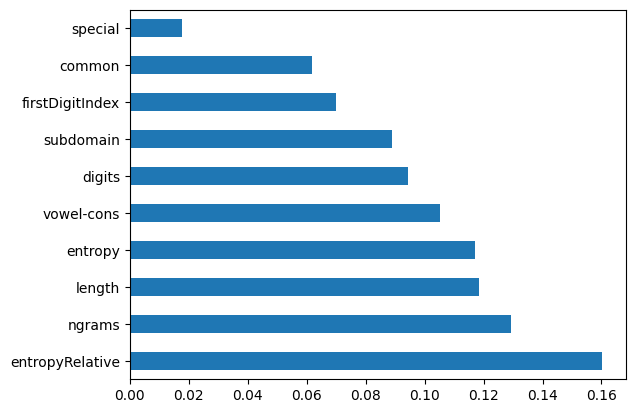

In [27]:
# Graph Feature Importance
feature_importances = pd.Series(model_Random_Forest.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

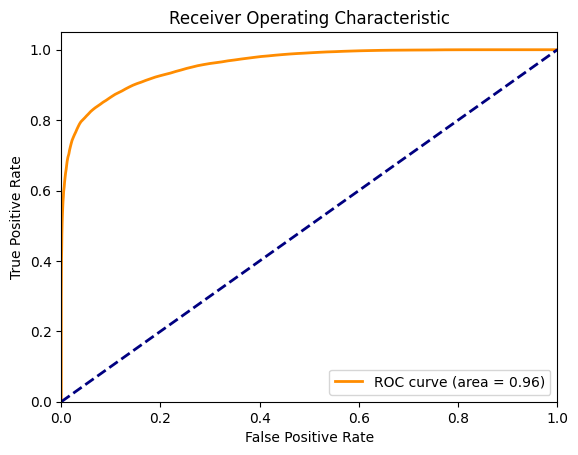

In [28]:
# Graph roc curve and auc score
from sklearn.metrics import roc_curve, auc

probabilities = model_Random_Forest.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()


In [33]:
# K fold Cross Validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_Random_Forest, X, y, cv=10, scoring='accuracy')

print("Scores")
print(scores)

# Overall model accuracy
print("Overall Model Accuracy")
print(scores.mean())

[0.89018228 0.89139751 0.89123413 0.88905945 0.89190572 0.88992293
 0.8927692  0.88921935 0.89133007 0.89027471]
0.89072953538716


#### ExtraTreesClassifier

              precision    recall  f1-score   support

           0       0.87      0.90      0.89     39093
           1       0.90      0.86      0.88     39080

    accuracy                           0.88     78173
   macro avg       0.88      0.88      0.88     78173
weighted avg       0.88      0.88      0.88     78173



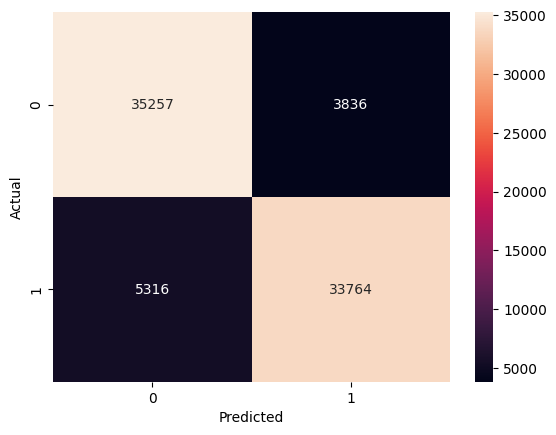

In [29]:
from sklearn.ensemble import ExtraTreesClassifier
model_Extra_Trees = ExtraTreesClassifier(n_estimators=100)
model_Extra_Trees.fit(X_train, y_train)

predictions = model_Extra_Trees.predict(X_test)

# Graph confusion matrix
cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(classification_report(y_test, predictions))

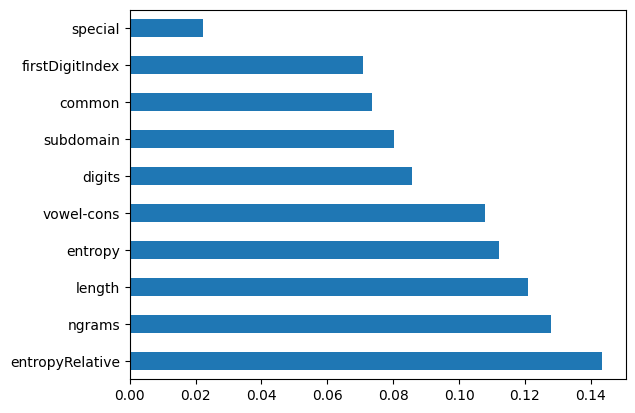

In [30]:
# Graph Feature Importance
feature_importances = pd.Series(model_Extra_Trees.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()


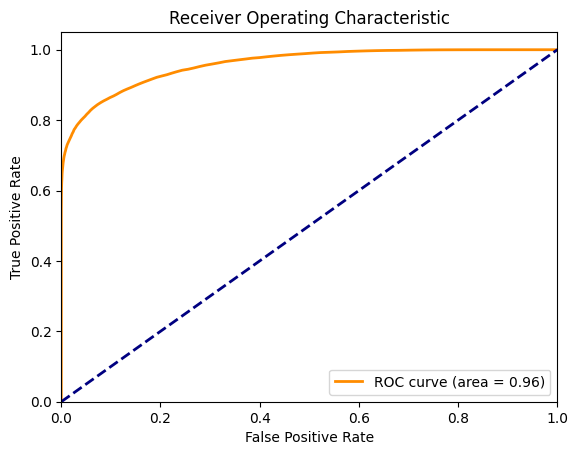

In [31]:
# Graph roc curve and auc score

probabilities = model_Extra_Trees.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

In [34]:
# K fold Cross Validation
scores = cross_val_score(model_Extra_Trees, X, y, cv=10, scoring='accuracy')

print("Scores")
print(scores)

# Overall model accuracy
print("Overall model accuracy")
print(scores.mean())

Scores
[0.89341222 0.89446754 0.8942403  0.89196968 0.89436822 0.89001887
 0.89401644 0.89264127 0.89382455 0.89267325]
Overall model accuracy
0.8931632355375708


In [32]:
# Guardar el modelo
import joblib
joblib.dump(model_Extra_Trees, './models/url_Extra_Trees_model.pkl')

['./models/url_Extra_Trees_model.pkl']